<a href="https://colab.research.google.com/github/MichaelBieri/Sequence-Forecast-Energy-Values-Stock-Prices-using-Multivariate-Analysis/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Unnamed: 0       Date  electricity_price  \
0            0 2014-01-01          17.282858   
1            1 2014-01-01          17.282858   
2            2 2015-01-01          18.428000   
3            3 2015-01-01          18.428000   
4            4 2015-01-01          18.428000   
5            5 2015-01-01          18.428000   
6            6 2015-01-01          18.428000   
7            7 2015-01-01          18.428000   
12          12 2016-01-01          18.252138   
11          11 2016-01-01          18.252138   
9            9 2016-01-01          18.252138   
8            8 2016-01-01          18.252138   
10          10 2016-01-01          18.252138   
13          13 2017-01-01          17.935080   
14          14 2017-01-01          17.935080   
18          18 2018-01-01          18.408220   
15          15 2018-01-01          18.408220   
16          16 2018-01-01          18.408220   
17          17 2018-01-01          18.408220   
21          21 2019-01-01          18.53

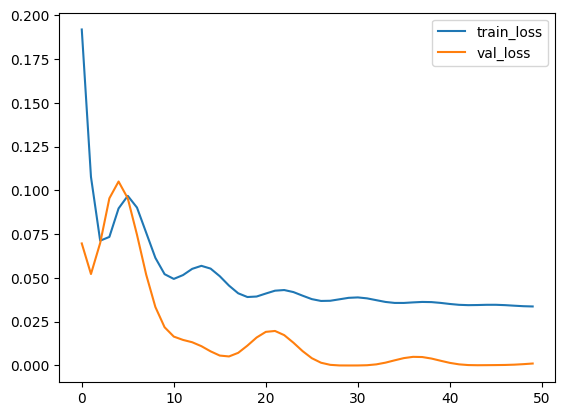

1/1 [==============================] - 0s 31ms/step - loss: 0.0011
Test Loss: 0.001124401343986392
1/1 [==============================] - 0s 498ms/step
[25.9711306  19.87448666]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'merged_data2.csv'
data = pd.read_csv(file_path)

# Parse dates
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
data = data.sort_values('Date')
print(data)

# Select features and target
features = ['electricity_price', 'global_economic_policy_uncertainty_index',
            'sustainable_development_goals_index', 'inflation', 'eu_inflation',
            'hydropower', 'photovoltaic', 'wind', 'nuclear',
            'eu_gross_electricity_production', 'eu_electricity_price',
            'growth_nominal_gross_domestic_product', 'swiss_growth_in_real_gross_domestic_product',
            'grid_usage_price', 'community_fees', 'feed_in_remuneration_at_cost_KEV',
            'swiss_environmental_performance_index']
target = 'electricity_price'

# Normalize the data
scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Create sequences
def create_sequences(data, target, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        features_seq = data.iloc[i:i+window_size][features].values
        target_seq = data.iloc[i+window_size][target]
        sequences.append((features_seq, target_seq))
    return sequences

window_size = 30
sequences = create_sequences(data, target, window_size)

# Split the data into train and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Prepare the data for the model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Define the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(window_size, len(features))))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict the next values
predictions = model.predict(X_test)

# Inverse transform the predictions
predicted_energy_costs = scaler.inverse_transform(np.hstack((X_test[:, -1, :], predictions)))

# Display the predictions
predicted_energy_costs = predicted_energy_costs[:, -1]
print(predicted_energy_costs)

